In [1]:
from collections import defaultdict
from copy import copy
import numpy as np
import operator
import os
import pickle

import pandas as pd
import tensorly as tl


import matplotlib.pyplot as plt
%pylab inline

from eval_tensor import VerbTensorEvaluator

import logging
logging.basicConfig(level=logging.INFO,
        format='%(levelname)-8s [%(lineno)d] %(message)s')

Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/vtensor/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1 One-mode similarity

## 1.1 Data

### 1.1.1 [SimVerb](http://people.ds.cam.ac.uk/dsg40/simverb.html) (Gerz+ EMNLP 2016)

In [2]:
simverb = pd.read_csv('/mnt/permanent/Language/English/Data/verb-similarity/simverb-3500/SimVerb-3500.txt', 
                      sep='\t', header=None, names=['verb1', 'verb2', 'pos', 'sim', 'rel'])

In [3]:
simverb.head()

,verb1,verb2,pos,sim,rel
0,take,remove,V,6.81,SYNONYMS
1,walk,trail,V,4.81,COHYPONYMS
2,feed,starve,V,1.49,ANTONYMS
3,shine,polish,V,7.80,SYNONYMS
4,calculate,add,V,5.98,HYPER/HYPONYMS


In [4]:
simverb.describe(percentiles=[])

,sim
count,3500.000000
mean,4.291554
std,2.652621
min,0.000000
50%,4.320000
max,9.960000


In [5]:
simverb.groupby('rel').sim.describe(percentiles=[]).sort_values('count', ascending=False)

,count,mean,std,min,50%,max
rel,,,,,,
NONE,2093.0,3.431276,2.342695,0.0,3.150,9.79
HYPER/HYPONYMS,800.0,6.012525,2.104537,0.5,6.310,9.96
SYNONYMS,306.0,6.789150,2.104490,0.5,7.140,9.96
COHYPONYMS,190.0,4.435526,2.381992,0.0,4.665,9.30
ANTONYMS,111.0,0.977748,1.074232,0.0,0.660,6.04


### 1.1.2 SimLex-999

In [6]:
simlex = pd.read_csv('/mnt/permanent/Language/English/Data/SimLex-999/SimLex-999.txt', sep='\t')

In [7]:
simlex.head()

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93


* conc(w1): The concreteness rating of word1 on a scale of 1-7. Taken from the University of South Florida Free Association Norms database. 

* conc(w2): The concreteness rating of word2 on a scale of 1-7. Taken from the University of South Florida Free Association Norms database. 

* concQ: The quartile the pair occupies based on the two concreteness ratings. Used for some analyses in the above paper. 

* Assoc(USF): The strength of free association from word1 to word2. Values are taken from the University of South Florida Free Association Dataset. 

* SimAssoc333: Binary indicator of whether the pair is one of the 333 most associated in the dataset (according to Assoc(USF)). This subset of SimLex999 is often the hardest for computational models to capture because the noise from high association can confound the similarity rating. See the paper for more details. 

* SD(SimLex): The standard deviation of annotator scores when rating this pair. Low values indicate good agreement between the 15+ annotators on the similarity value SimLex999. Higher scores indicate less certainty. 


In [8]:
simlex.describe(percentiles=[])

,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,4.561572,3.657087,3.568629,2.501502,0.751512,0.333333,1.274505
std,2.614663,1.131050,1.159572,1.118145,1.344569,0.471641,0.366278
min,0.230000,1.190000,1.190000,1.000000,0.000000,0.000000,0.340000
50%,4.670000,3.830000,3.660000,3.000000,0.250000,0.000000,1.310000
max,9.800000,5.000000,5.000000,4.000000,8.850000,1.000000,2.180000


In [9]:
simlex.groupby('POS').size()

POS
A    111
N    666
V    222
dtype: int64

## 1.2 Testing the verb tensor

In [10]:
weights = ["iact" ,"iact_sali" ,"ldice" ,"ldice_sali" ,"log_freq" ,"niact" ,"npmi" ,"pmi" ,"pmi_sali"]

cutoffs = []
for i in [1, 2, 3, 5]:
    cutoffs += list(i*10**np.arange(2, 9))

def eval_for_for(task_df0, mode_to_test, algo='tucker'):
    # normlz_vocb=True, lmbda=False, decomp_algo='tucker', weight_name='log_freq'
    data = []
    for non_negative in range(2):
        for cutoff in cutoffs:
            for exp in range(10):
                rank = 2**exp
                for weight in weights:
                    try:
                        evalor = VerbTensorEvaluator(non_negative=non_negative, decomp_algo=algo, 
                                                     rank=rank, cutoff=cutoff, weight=weight, 
                                                     mode_to_test=mode_to_test)
                        score = evalor.test_sim(task_df0)
                        data.append((cutoff, rank, weight, non_negative, algo, score))
                    except FileNotFoundError:
                        pass
                    except ValueError as e:
                        logging.warning((cutoff, rank, e))
    df = pd.DataFrame(data, columns=['cutoff', 'rank', 'weight', 'non_negative', 'algo', 'corr'])
    return df.sort_values('corr', ascending=False)

In [11]:
df_s = eval_for_for(simlex, mode_to_test='nsubj')#, cutoff=500, rank=32)['tensor_sim']

In [12]:
df_s.head()

,cutoff,rank,weight,non_negative,algo,corr
45,50000,256,npmi,0,tucker,0.097404
15,100000,256,npmi,0,tucker,0.080425
43,50000,128,npmi,0,tucker,0.076786
14,100000,128,npmi,0,tucker,0.072204
22,200000,256,npmi,0,tucker,0.069937


In [13]:
def best_cutoff(df):
    index_like = ['rank', 'weight', 'non_negative', 'algo']
    df1 = df.sort_values(index_like+['corr'], ascending=False).drop_duplicates(index_like)
    return df1.sort_values('corr', ascending=False)

In [14]:
df_v = eval_for_for(simverb, mode_to_test='ROOT')#, cutoff=500, rank=32)['tensor_sim']

In [15]:
best_cutoff(df_v).head()

,cutoff,rank,weight,non_negative,algo,corr
45,50000,256,npmi,0,tucker,0.220297
43,50000,128,npmi,0,tucker,0.197490
44,50000,128,pmi,0,tucker,0.193884
39,50000,64,npmi,0,tucker,0.190974
42,50000,128,log_freq,0,tucker,0.189700


In [16]:
df_v[df_v.non_negative==1]

,cutoff,rank,weight,non_negative,algo,corr
49,300000,32,npmi,1,tucker,0.030793
58,300000,64,pmi_sali,1,tucker,0.029458
57,300000,64,pmi,1,tucker,0.027933
56,300000,64,npmi,1,tucker,0.027400
59,300000,128,npmi,1,tucker,0.024331
61,500000,64,npmi,1,tucker,0.018919
51,300000,64,iact_sali,1,tucker,0.016581
55,300000,64,niact,1,tucker,0.007770
50,300000,64,iact,1,tucker,0.005667
52,300000,64,ldice,1,tucker,-0.033290


In [17]:
df_o = eval_for_for(simlex, mode_to_test='dobj')

In [18]:
best_cutoff(df_o).head()

,cutoff,rank,weight,non_negative,algo,corr
45,50000,256,npmi,0,tucker,0.166328
43,50000,128,npmi,0,tucker,0.123943
44,50000,128,pmi,0,tucker,0.123037
26,30000,128,log_freq,0,tucker,0.095198
20,20000,64,log_freq,0,tucker,0.087065


In [19]:
df_o[df_o.non_negative==1]

,cutoff,rank,weight,non_negative,algo,corr
48,1000000,64,log_freq,1,tucker,-0.058564
61,500000,64,npmi,1,tucker,-0.080168
59,300000,128,npmi,1,tucker,-0.083803
57,300000,64,pmi,1,tucker,-0.089104
58,300000,64,pmi_sali,1,tucker,-0.089517
51,300000,64,iact_sali,1,tucker,-0.090162
60,500000,64,log_freq,1,tucker,-0.090708
56,300000,64,npmi,1,tucker,-0.090868
50,300000,64,iact,1,tucker,-0.090950
55,300000,64,niact,1,tucker,-0.091513


In [20]:
def plot_cutoff(df, col):
    for weight in df.weight.unique():
        df0 = df[(df.weight==weight)&(df.rank_==256)]
        plt.plot(df0.cutoff, df0[col])
        plt.legend(df.weight.unique())

In [21]:
def plot_rank(df, col):
    for weight in df.weight.unique():
        df0 = df[(df.weight==weight)&(df.cutoff==100)]
        plt.plot(df0.rank_, df0[col])
        plt.legend(df.weight.unique())

In [22]:
if False:
    df = compare_100_256(simverb, 'ROOT', 'sim')
    plot_cutoff(df, 'sim')
    plot_rank(df, 'sim')
    df = compare_100_256(simlex, mode_to_test='nsubj', col='SimLex999')
    plot_cutoff(df, 'SimLex999')
    plot_rank(df, 'SimLex999')
    df = compare_100_256(simlex, mode_to_test='dobj', col='SimLex999')
    plot_cutoff(df, 'SimLex999')
    plot_rank(df, 'SimLex999')

In [23]:
def plot_results(df0, col='sim', save_filen=''):#else ''
    
    df0 = df0[df0.rank_ ==256]
    weights = pd.unique(df0.sort_values(col, ascending=False).weight)
    for weight in weights:
        df = df0[df0.weight==weight].sort_values('rank_')
        plt.plot(df.rank_, df[col])#, c=color)
    #plt.xscale('log')
    _ = plt.legend(weights)
    if save_filen:
        #plt.rc('text', usetex = True)
        #plt.figure(1, figsize = (3, 2))#6, 4))
        #plt.savefig('/home/makrai/repo/paper/LREC20/verbtensor/img/{}'.format(save_filen))
        filen = '/home/makrai/repo/paper/Coling2020/verbtensor/img/{}.png'.format(save_filen)
        plt.savefig(filen)

In [24]:
#plot_results(simverb_res)#, save_filen='SimVerb')

In [25]:
#plot_results(simlex_subj, col='SimLex999')#, save_filen='simLex-subj')

In [26]:
#plot_results(simlex_obj, col='SimLex999')#, save_filen='simLex-obj')

# 2 SVO triples (_al et_ Sadrzadeh 2011--2014)

## 2.1 Datasets

  * [GS’11](http://www.cs.ox.ac.uk/activities/compdistmeaning/GS2011data.txt) provided by Grefenstette and Sadrzadeh (EMNLP 2011)
      * each verb pair takes the same subject and object
      * the task has an aspect of a verb sense disambiguation 
          * As discussed in previous work
            (Kartsaklis and Sadrzadeh, 2013; Milajevs+ 2014; Polajnar+ 2014), GS’11
      * For example, the transitive verb “run” is known as polysemous: operate/move
        * “run” and “operate” are similar when subj = “people” and obj = “company”
        * In the same [context, not similar to] “move”
  * ML’10 provided by Mitchell and Lapata (2010),
    * pairs of verb-object phrases and
  * KS’13 provided by Kartsaklis and Sadrzadeh (2013)
    * complements ML’10 by incorporating an appropriate subject for each VO
  * KS’14 provided by [Kartsaklis and Sadrzadeh (2014)](https://arxiv.org/abs/1405.2874)
    * reannotated version of KS’13 using a cloud sourcing service
  * the latter three require one to capture the topical similarity
    rather than the disambiguation aspect (Polajnar+ 2014)

In [27]:
verb_sim_data_dir = '/mnt/permanent/Language/English/Data/verb-similarity/Sadrzadeh/'

In [28]:
def read_sim_data(filen):
    return pd.read_csv(os.path.join(verb_sim_data_dir, filen), sep=' ')

### 2.1.1 Pairs of SVO triples with the same but ambiguous verb (GS11)

In [29]:
gs11 = read_sim_data('GS2011data.txt').groupby(['verb', 'subject', 'object', 'landmark', 'hilo']).mean()
print(gs11.shape)
gs11.head()

(200, 1)


input
verb   subject    object         landmark hilo          
accept government proposal       bear     LOW   2.666667
                                 receive  HIGH  2.583333
                  recommendation bear     LOW   3.500000
                                 receive  HIGH  3.333333
       lawyer     conviction     bear     LOW   3.333333

In [30]:
gs11.groupby('verb').size().sort_values(ascending=False).head()

verb
accept     20
buy        20
draw       20
meet       20
provide    20
dtype: int64

In [31]:
gs11.groupby('landmark').size().sort_values(ascending=False).head()

landmark
allege     10
attract    10
test       10
supply     10
state      10
dtype: int64

In [32]:
cols = ['sentence_id', 'adj_subj', 'subj', 'landmark', 'verb', 'adj_obj', 'obj']
gs12 = read_sim_data('GS2012data.txt').groupby(cols).mean().drop(columns=['annotator_id'])
gs12.head()

,,,,,,,annotator_score
sentence_id,adj_subj,subj,landmark,verb,adj_obj,obj,
1,statistical,table,show,express,good,result,6.06
2,statistical,table,show,depict,good,result,5.90
3,recent,study,show,express,significant,correlation,5.72
4,recent,study,show,depict,significant,correlation,5.92
5,annual,figure,show,express,substantial,increase,5.74


In [33]:
cols = ['sentence_id', 'adj_subj', 'subj', 'landmark', 'verb', 'adj_obj', 'obj']
gsk13 = read_sim_data('pickering-judgements.txt').groupby(cols).mean().drop(columns=['annotator_id'])
gsk13.head()

,,,,,,,annotator_score
sentence_id,adj_subj,subj,landmark,verb,adj_obj,obj,
1,private,company,file,register,annual,account,5.441860
2,private,company,file,smooth,annual,account,2.302326
3,young,woman,file,register,long,nail,2.069767
4,young,woman,file,smooth,long,nail,5.023256
5,local,government,file,register,criminal,charge,5.441860


In [34]:
cols = ['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']
ks13_mitchell = read_sim_data('emnlp2013_ml.txt').groupby(cols).mean()
print(ks13_mitchell.shape)
ks13_mitchell.head()

(108, 1)


score
subject1 verb1 object1  subject2 verb2 object2          
agent    sell  property family   buy   home     2.777778
                        group    hold  meeting  1.666667
author   write book     delegate buy   land     1.500000
                        man      hear  word     2.055556
                        writer   read  word     2.777778

In [35]:
def get_cols(i):
    return ['subject{}'.format(i), 'verb{}'.format(i), 'object{}'.format(i)]

def get_one_sent_from_pair(i):
    df = ks13_mitchell.reset_index()[get_cols(i)]
    df.columns = get_cols('')
    return df

ks13_long = pd.concat(get_one_sent_from_pair(i) for i in [1, 2])
ks13_long = ks13_long.drop_duplicates()

### 2.1.2 Kartsaklis and Sadrzadeh, Turk

In [36]:
cols = ['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']
ks13_turk = read_sim_data('emnlp2013_turk.txt').groupby(cols).mean().drop(columns=['annotator']).reset_index()
ks13_turk.head()

,subject1,verb1,object1,subject2,verb2,object2,score
0,agent,sell,property,family,buy,home,3.125000
1,agent,sell,property,group,hold,meeting,1.166667
2,author,write,book,delegate,buy,land,1.130435
3,author,write,book,man,hear,word,1.640000
4,author,write,book,writer,read,word,3.166667


In [37]:
ks13_turk.groupby('verb1').size().sort_values(ascending=False).head()

verb1
achieve    5
use        5
win        4
provide    4
fight      3
dtype: int64

In [38]:
ks13_turk.groupby('verb2').size().sort_values(ascending=False).head()

verb2
use        7
provide    5
leave      4
buy        4
reach      3
dtype: int64

### 2.1.3 [Verb prediction task by Jenatton+ (NIPS 2012)](https://everest.hds.utc.fr/doku.php?id=en:lfmnips12)

In [39]:
dataset_dir = '/mnt/permanent/Language/English/Data/verb-similarity/SVO-tensor-dataset/'
def get_index(pos):
    with open(os.path.join(dataset_dir, 'svo-{}s.lst'.format(pos))) as infile:
        return {i+1: ' '.join(line.strip().split('_')[2:-1]) for i, line in enumerate(infile)}

In [40]:
svo_df = pd.read_csv(os.path.join(dataset_dir, 'svo_data_train_1000000.dat'), sep='\t', header=None, 
                     names=['subject', 'verb', 'object'])

In [41]:
index_verb = get_index('verb')
index_noun = get_index('noun')

In [42]:
svo_df.subject = svo_df.subject.apply(index_noun.get)
svo_df.verb = svo_df.verb.apply(index_verb.get)
svo_df.object = svo_df.object.apply(index_noun.get)

In [43]:
svo_df.sample(5)

,subject,verb,object
125778,queen,try,favor
20410,white paper,introduce,time
311007,unit,refuse,battle
54497,success,sell,unit
559594,blow,consist,classic


## 2.2 Similarity (KS Turk)

In [44]:
df = eval_for_for(ks13_turk, mode_to_test='svo')

In [45]:
df.sort_values('corr', ascending=False).head(6)

,cutoff,rank,weight,non_negative,algo,corr
10,100000,64,npmi,0,tucker,0.719182
12,100000,64,pmi_sali,0,tucker,0.704931
39,50000,64,npmi,0,tucker,0.703139
8,100000,64,log_freq,0,tucker,0.688340
37,50000,64,log_freq,0,tucker,0.683899
36,50000,64,ldice_sali,0,tucker,0.681383


In [46]:
height = 5
pylab.rcParams['figure.figsize'] = (2*height, height)
matplotlib.rcParams.update({'font.size': 11})

In [47]:
columns = ['log_freq', 'npmi', 'pmi_sali', 'pmi', 'niact', 'iact_sali', 'iact', 'ldice_sali', 'ldice']

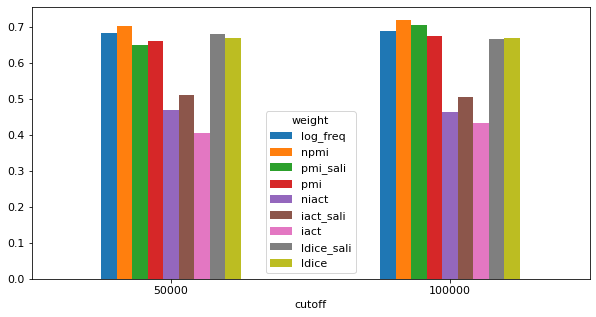

In [49]:
df1 = df[(df.non_negative==0)&(df.algo=='tucker')&(df['rank']==64)&(df.cutoff>=50000)&(df.cutoff<=100000)]
df1.pivot_table('corr', ['cutoff'], 'weight')[columns].plot(kind='bar', rot=0)
plt.savefig('/home/makrai/repo/paper/CONLL21/verbtensor/img/svo-64')

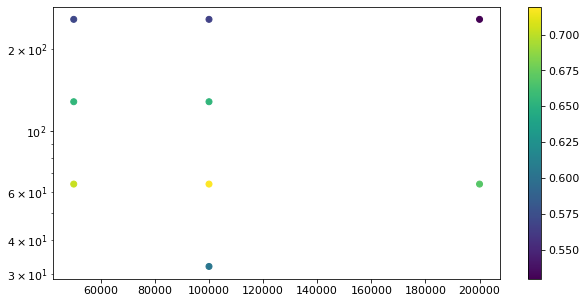

In [50]:
df1 = df[(df.non_negative==0)&(df.algo=='tucker')&(df['weight']=='npmi')]
plt.scatter(df1.cutoff, df1['rank'], c=df1['corr'])
#plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.savefig('/home/makrai/repo/paper/CONLL21/verbtensor/img/svo-npmi-scatter.png')

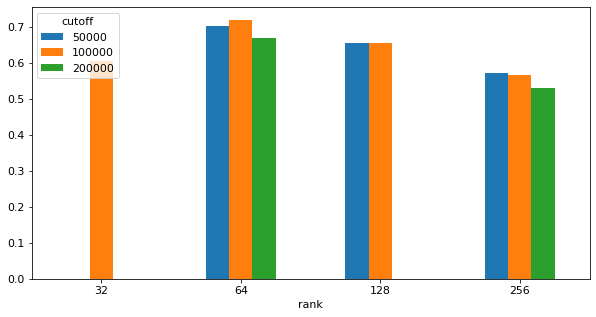

In [51]:
df2 = df[(df.weight=='npmi')&(df.non_negative==False)]
df2.pivot_table('corr', 'rank', 'cutoff').plot(kind='bar', rot=0)
plt.savefig('/home/makrai/repo/paper/CONLL21/verbtensor/img/svo-npmi-bar.png')

In [52]:
df[df.non_negative==1]

,cutoff,rank,weight,non_negative,algo,corr
58,300000,64,pmi_sali,1,tucker,0.336537
56,300000,64,npmi,1,tucker,0.303251
49,300000,32,npmi,1,tucker,0.289490
61,500000,64,npmi,1,tucker,0.264189
57,300000,64,pmi,1,tucker,0.259477
59,300000,128,npmi,1,tucker,0.225085
51,300000,64,iact_sali,1,tucker,0.218067
55,300000,64,niact,1,tucker,0.213679
50,300000,64,iact,1,tucker,0.201562
53,300000,64,ldice_sali,1,tucker,0.081624


In [53]:
df_p = eval_for_for(ks13_turk, mode_to_test='svo', algo='parafac')

In [54]:
df_p

,cutoff,rank,weight,non_negative,algo,corr
28,50000,256,npmi,0,parafac,0.554575
25,50000,128,npmi,0,parafac,0.534697
18,50000,64,npmi,0,parafac,0.527507
9,100000,128,npmi,0,parafac,0.513270
27,50000,128,pmi_sali,0,parafac,0.492462
16,30000,128,npmi,0,parafac,0.490852
26,50000,128,pmi,0,parafac,0.486816
8,100000,64,pmi_sali,0,parafac,0.475076
21,50000,128,ldice,0,parafac,0.451610
15,30000,64,npmi,0,parafac,0.449384


<AxesSubplot:xlabel='weight'>

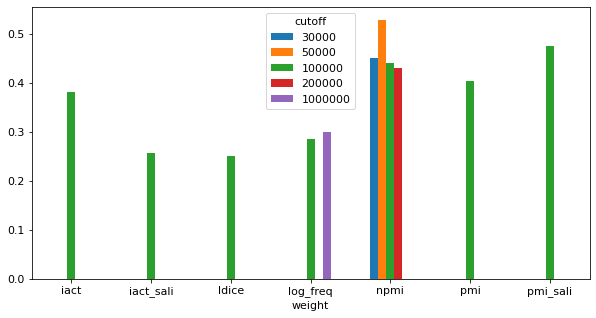

In [55]:
df_p[df_p['rank']==64].pivot_table('corr', 'weight', 'cutoff').plot(kind='bar', rot=0)

## 2.3 Verb prediction

In [56]:
gs11.shape

(200, 1)

In [57]:
gs_rank = 256

In [58]:
%time VerbTensorEvaluator(rank=gs_rank).predict_verb(gs11.reset_index())

INFO     [184] verb	npmi	256	100000	61


CPU times: user 8min 55s, sys: 36.4 s, total: 9min 31s
Wall time: 1min 6s


In [59]:
for weight in weights:
    try:
        VerbTensorEvaluator(rank=gs_rank, weight=weight).predict_verb(gs11.reset_index())
    except FileNotFoundError:
        pass

INFO     [184] verb	npmi	256	100000	61


In [60]:
VerbTensorEvaluator(rank=128).predict_verb(gs11.reset_index())

INFO     [184] verb	npmi	128	100000	43


In [61]:
for cutoff in [50000,200000]:
    try:
        VerbTensorEvaluator(rank=gs_rank, cutoff=cutoff).predict_verb(gs11.reset_index())
    exceptept FileNotFoundError:
        pass

SyntaxError: invalid syntax (<ipython-input-61-1f61d45c2d98>, line 4)

In [ ]:
#VerbTensorEvaluator().predict_verb(svo_df) # Jenatton

In [ ]:
ks13_turk.shape

In [ ]:
VerbTensorEvaluator().predict_verb(ks13_turk, cols_suff=1)

In [ ]:
VerbTensorEvaluator().predict_verb(ks13_turk, cols_suff=2)

## Attic: Exploring GS11

In [ ]:
svo_sim = gs11.reset_index()

In [ ]:
svo_sim.hilo = (svo_sim=='HIGH').astype(int)

In [ ]:
cols_ordered = ["subject", "verb", "landmark", "object", "input", "hilo"]

In [ ]:
svo_sim[cols_ordered].head()

In [ ]:
svo_sim.groupby('landmark').size().sort_values(ascending=False)

In [ ]:
svo_sim.groupby('verb').size().sort_values(ascending=False)

In [ ]:
svo_sim.describe(percentiles=[])

In [ ]:
svo_sim.corr(method='spearman')

In [ ]:
def eval_for_weight(task_df0, mode_to_test='svo', cutoff=2000, rank=128):
    # normlz_vocb=True, lmbda=False, decomp_algo='tucker', weight_name='log_freq'
    data = []
    for weight_name in weights:
        try:
            score_d = evalor.test_sim(task_df0, mode_to_test=mode_to_test, 
                                      cutoff=cutoff, rank=rank, weight=weight_name)
            data.append((cutoff, rank, weight_name, score_d))
        except FileNotFoundError as e:
            logging.warning(weight_name)
        except ValueError as e:
            logging.warning((cutoff, rank, e))
    df = pd.DataFrame(data, columns=['cutoff', 'rank', 'weight', 'corr'])
    return df.sort_values('corr', ascending=False)